In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv")

In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()            # Is this data having any NULL value

False

In [6]:
df.head

<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.

In [7]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale = 0.8)

rcParams['figure.figsize'] = 7, 4

# RANDOM_SEED, LABELS
RANDOM_SEED = 0xCAFE
LABELS = ["Normal", "Fraud"]

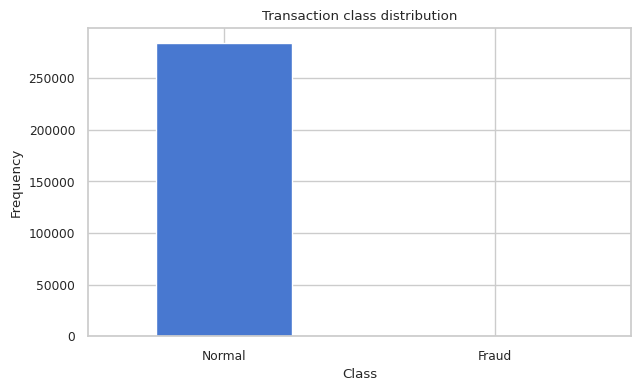

In [8]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [9]:
# Data classification
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [10]:
normal.shape

(284315, 31)

In [11]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normal.Amount.describe()            # Normal transactions are much frequent than the frauds

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

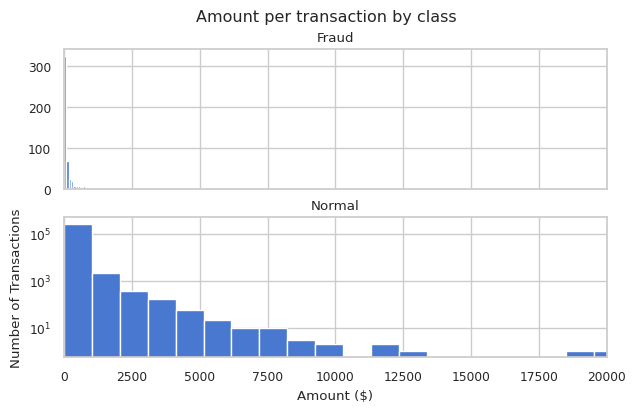

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 25           # histogram

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

In [14]:
# Data preprocessing for models
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis = 1)          # discard irrelevant column
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size = 0.2, random_state = RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis = 1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis = 1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227444, 29)

In [15]:
# Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(encoding_dim,
                 activation = "tanh",
                 activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(int(encoding_dim / 2), activation="relu")(encoder1)
encoder3 = Dense(int(encoding_dim / 4), activation="relu")(encoder2)

decoder1 = Dense(int(encoding_dim / 4), activation='tanh')(encoder3)
decoder2 = Dense(int(encoding_dim / 2), activation='tanh')(decoder1)
decoder3 = Dense(int(encoding_dim), activation='tanh')(decoder2)

decoder = Dense(input_dim, activation='relu')(decoder3)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [40]:
nb_epoch = 15
batch_size = 32
autoencoder.compile(optimizer = 'adam',
                    loss = 'mean_squared_error',
                    metrics = ['accuracy'])

checkpoint = ModelCheckpoint(filepath = "best-model.h5",
                               verbose = 0,
                               save_best_only = True)

history = autoencoder.fit(X_train, X_train,
                    epochs = nb_epoch,
                    batch_size = batch_size,
                    shuffle = True,
                    validation_data = (X_test, X_test),
                    verbose = 1,
                    callbacks = [checkpoint]).history

Epoch 1/100
7108/7108 [==============================] - 32s 4ms/step - loss: 0.6719 - accuracy: 0.7883 - val_loss: 0.6459 - val_accuracy: 0.8586
Epoch 2/100
7108/7108 [==============================] - 27s 4ms/step - loss: 0.6316 - accuracy: 0.8462 - val_loss: 0.6403 - val_accuracy: 0.8378
Epoch 3/100
7108/7108 [==============================] - 23s 3ms/step - loss: 0.6254 - accuracy: 0.8547 - val_loss: 0.6378 - val_accuracy: 0.8671
Epoch 4/100
7108/7108 [==============================] - 22s 3ms/step - loss: 0.6191 - accuracy: 0.8665 - val_loss: 0.6266 - val_accuracy: 0.8823
Epoch 5/100
7108/7108 [==============================] - 22s 3ms/step - loss: 0.6157 - accuracy: 0.8746 - val_loss: 0.6456 - val_accuracy: 0.8125
Epoch 6/100
7108/7108 [==============================] - 22s 3ms/step - loss: 0.6181 - accuracy: 0.8730 - val_loss: 0.6271 - val_accuracy: 0.8853
Epoch 7/100
7108/7108 [==============================] - 21s 3ms/step - loss: 0.6148 - accuracy: 0.8750 - val_loss: 0.6253 -

In [42]:
autoencoder = load_model('best-model.h5')

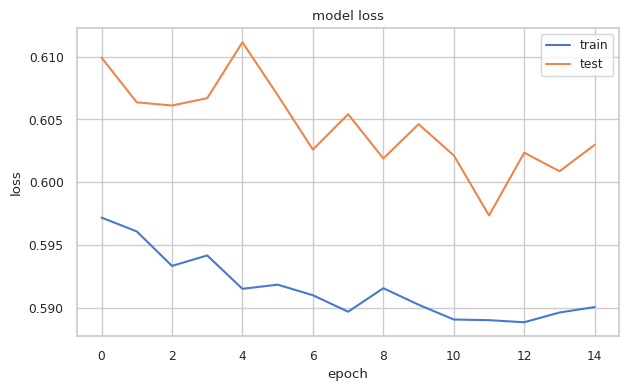

In [43]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [44]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1781/1781 [==============================] - 3s 2ms/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.595373,0.001598
std,3.256165,0.039938
min,0.024901,0.000000
25%,0.177664,0.000000
50%,0.299133,0.000000
75%,0.498407,0.000000
max,396.895140,1.000000


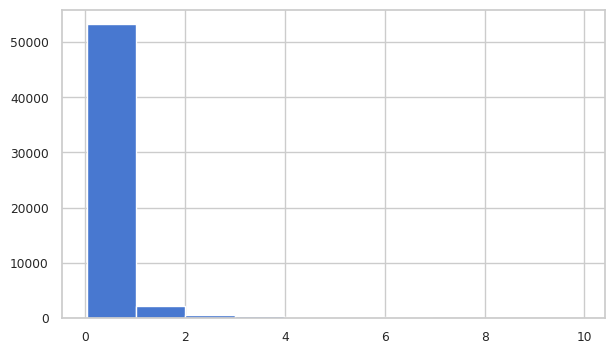

In [47]:
# Reconstruction error distribution about normal transaction data
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

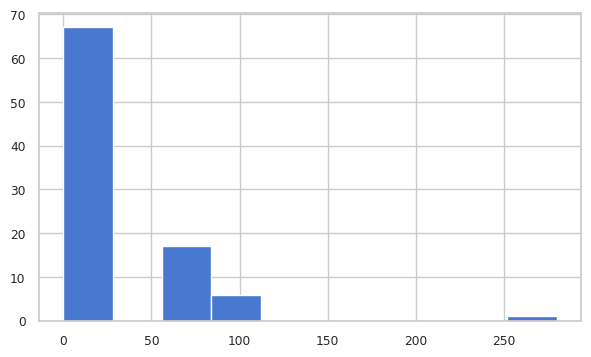

In [48]:
# Reconstruction error distribution about abnormal(fraud) transaction data
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

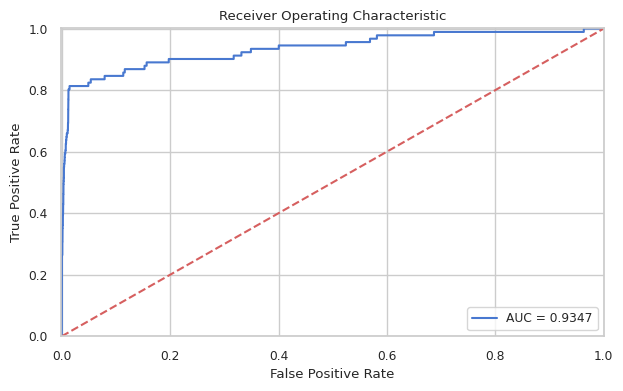

In [49]:
# Evaluation with ROC curve
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

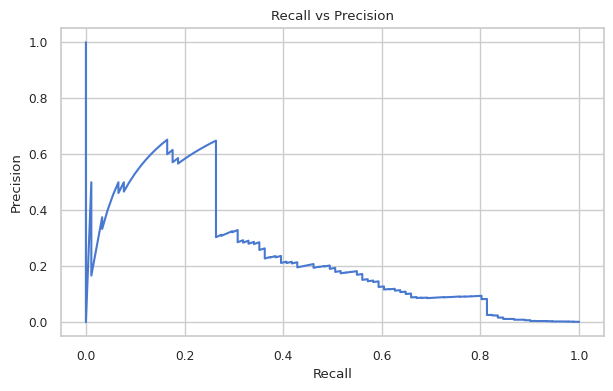

In [50]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

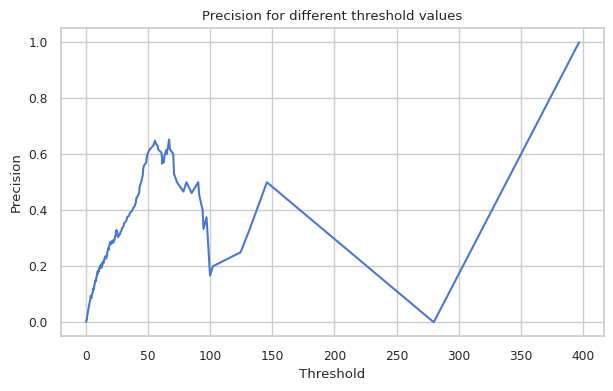

In [51]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

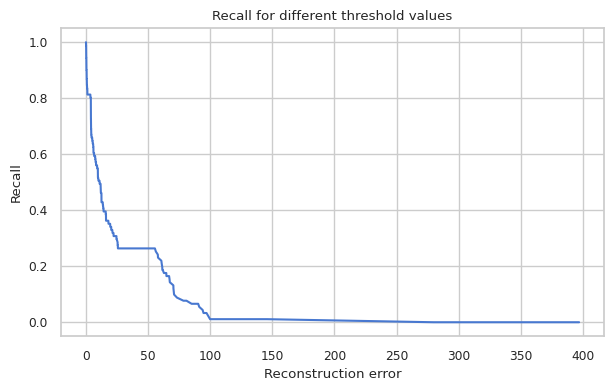

In [52]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

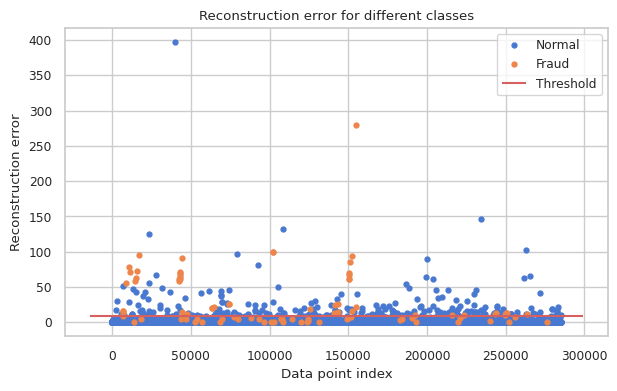

In [60]:
threshold = 9

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

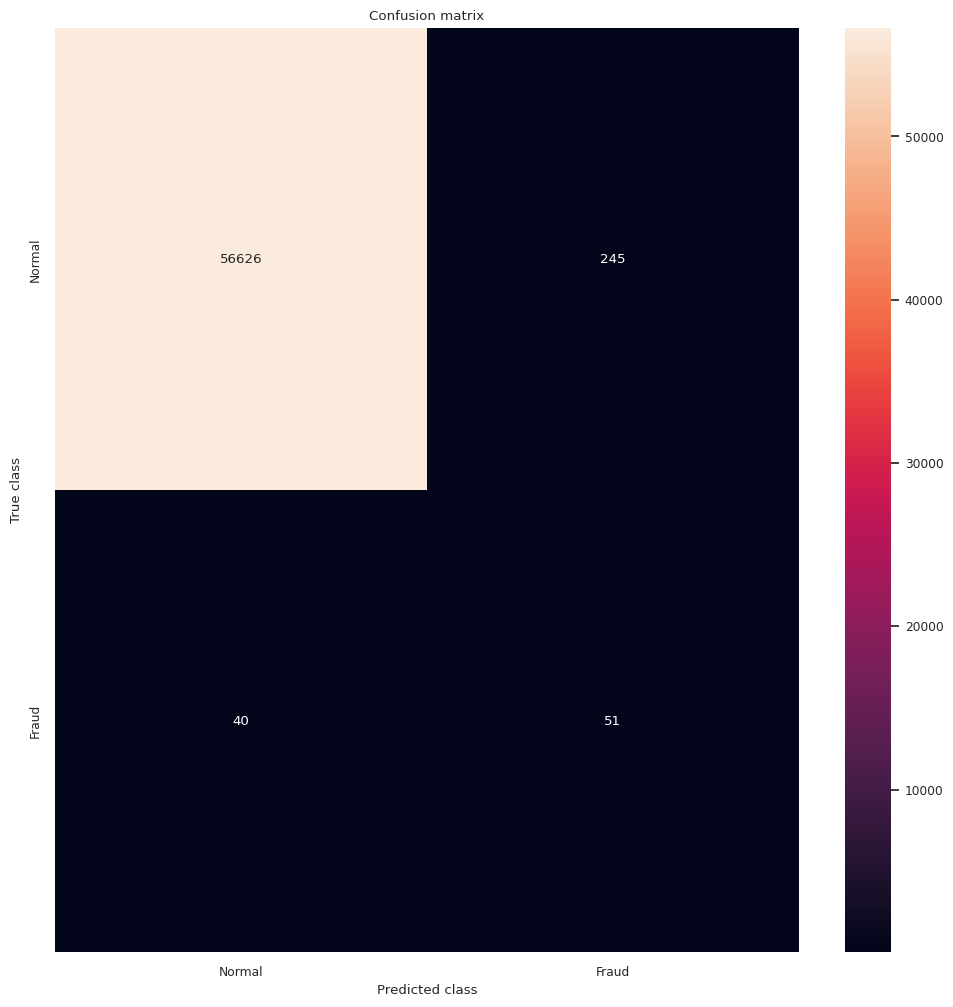

In [61]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()